### **Stap 2: Data ophalen van Coinbase**

In [1]:
import requests
import pandas as pd

def fetch_coinbase_data(symbol="XRP-USD", granularity=3600):
    """
    Haalt historische data op van Coinbase.
    Args:
    - symbol (str): Het trading pair, bijvoorbeeld 'XRP-USD'.
    - granularity (int): Interval in seconden (bijv. 3600 = 1 uur).
    """
    url = f"https://api.exchange.coinbase.com/products/{symbol}/candles"
    params = {
        "granularity": granularity  # Tijdinterval, bijvoorbeeld 3600s = 1 uur
    }
    response = requests.get(url, params=params)

    if response.status_code != 200:
        raise Exception(f"API Error: {response.status_code}, {response.text}")
    
    # Converteer de data naar een Pandas DataFrame
    data = response.json()
    df = pd.DataFrame(data, columns=["time", "low", "high", "open", "close", "volume"])
    
    # Converteer de tijdstempel naar datetime
    df["time"] = pd.to_datetime(df["time"], unit="s")
    
    # Sorteer op tijd
    df = df.sort_values(by="time").reset_index(drop=True)
    return df

# Voorbeeldgebruik
df = fetch_coinbase_data(symbol="XRP-USD", granularity=3600)
print(df.head())

                 time     low    high    open   close        volume
0 2024-12-25 07:00:00  2.2771  2.3032  2.2903  2.2835  1.969920e+06
1 2024-12-25 08:00:00  2.2785  2.2961  2.2835  2.2882  1.638760e+06
2 2024-12-25 09:00:00  2.2850  2.3010  2.2879  2.2927  1.966045e+06
3 2024-12-25 10:00:00  2.2903  2.3308  2.2930  2.3016  2.925176e+06
4 2024-12-25 11:00:00  2.2660  2.3118  2.3011  2.2703  2.776888e+06


### **Stap 3: Data voorbereiden**

1. Visualiseer de sluitingsprijzen

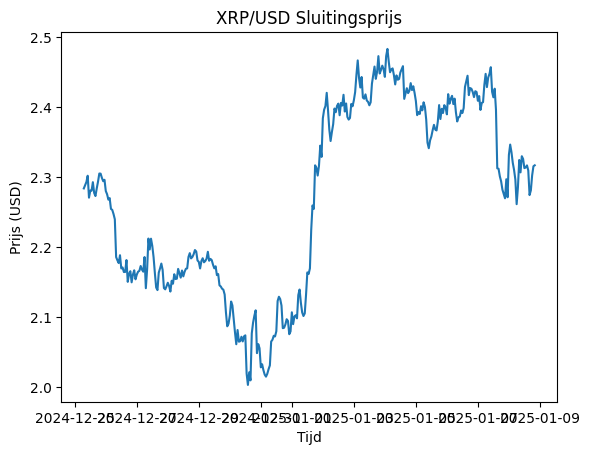

In [2]:
import matplotlib.pyplot as plt

plt.plot(df["time"], df["close"])
plt.title("XRP/USD Sluitingsprijs")
plt.xlabel("Tijd")
plt.ylabel("Prijs (USD)")
plt.show()

2. Normaliseer de data

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df["close_scaled"] = scaler.fit_transform(df[["close"]])

3. Trainingsset maken

In [4]:
import numpy as np

def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

close_prices = df["close_scaled"].values
X, y = create_sequences(close_prices, lookback=60)
print(f"Input shape: {X.shape}, Output shape: {y.shape}")

Input shape: (290, 60), Output shape: (290,)


### **Stap 4: Bouw een LSTM-model**

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Model bouwen
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

# Trainen
X_train = X.reshape(X.shape[0], X.shape[1], 1)  # LSTM verwacht 3D input
model.fit(X_train, y, epochs=10, batch_size=32)

Epoch 1/10


c:\Users\NvanOort\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2268
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0267
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0119
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0090
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0087
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0067
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0067
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0066
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0059
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0057


### **Stap 5: Voorspellen en visualiseren**

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


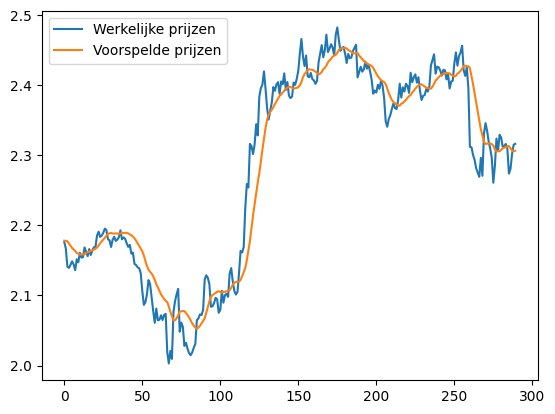

In [6]:
# Voorspellen
predicted = model.predict(X_train)
predicted_prices = scaler.inverse_transform(predicted)  # Denormaliseer

# Plot de resultaten
plt.plot(df["close"].values[60:], label="Werkelijke prijzen")
plt.plot(predicted_prices, label="Voorspelde prijzen")
plt.legend()
plt.show()